# 823 HW5 Candice Li
This project is used to classify different insects (beetle, dragonfly, and cockroach) 
using a `tf.keras.Sequential` model.
We will split the training dataset into train and validation and then evaluate the model 
using the test dataset.
Then we will let this model predict an image to see if it gets the correct outcome.

## import the needed packages 

In [3]:
import PIL
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Define file path

In [4]:
path_train = 'train/'
path_test = 'test/'

In [5]:
batch_size = 32
img_height = 180
img_width = 180

## Read training data and split into training and validation at ratio 0.2

In [93]:
tr_ds = tf.keras.utils.image_dataset_from_directory(
  path_train,
  validation_split=0.2,
  subset="training",
  seed =123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1019 files belonging to 3 classes.
Using 816 files for training.


In [90]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path_train,
  validation_split=0.2,
  subset="validation",
  seed =123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1019 files belonging to 3 classes.
Using 203 files for validation.


## Show some sample plots

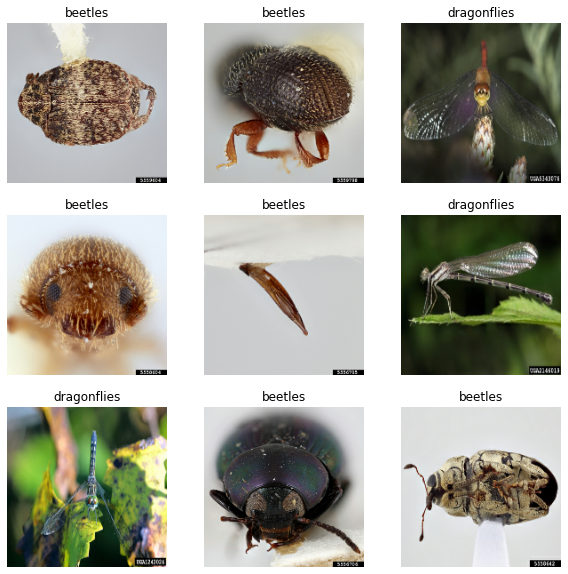

In [94]:
plt.figure(figsize=(10, 10))
for images, labels in tr_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in tr_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


## Configure the dataset for performance

In [95]:
AUTOTUNE = tf.data.AUTOTUNE

tr_ds = tr_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = tr_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.99623764


## Data augmentation
Generate more data from exisiting examples by augmenting them using random transformations

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Create the model using augmented data and use dropout to avoid overfitting

In [111]:
num_classes = 3

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [112]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

In [113]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

## Train the model

In [114]:
epochs = 15
history = model.fit(
  tr_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
26/26 [==============================] - 12s 432ms/step - loss: 1.0776 - accuracy: 0.5453 - val_loss: 0.7421 - val_accuracy: 0.6404
Epoch 2/15
26/26 [==============================] - 11s 430ms/step - loss: 0.6459 - accuracy: 0.7451 - val_loss: 0.4480 - val_accuracy: 0.8128
Epoch 3/15
26/26 [==============================] - 11s 427ms/step - loss: 0.5108 - accuracy: 0.8027 - val_loss: 0.3614 - val_accuracy: 0.8276
Epoch 4/15
26/26 [==============================] - 11s 430ms/step - loss: 0.4420 - accuracy: 0.8419 - val_loss: 0.4455 - val_accuracy: 0.8128
Epoch 5/15
26/26 [==============================] - 11s 427ms/step - loss: 0.4379 - accuracy: 0.8321 - val_loss: 0.4074 - val_accuracy: 0.8276
Epoch 6/15
26/26 [==============================] - 11s 431ms/step - loss: 0.3740 - accuracy: 0.8505 - val_loss: 0.3542 - val_accuracy: 0.8571
Epoch 7/15
26/26 [==============================] - 11s 424ms/step - loss: 0.3789 - accuracy: 0.8542 - val_loss: 0.4123 - val_accuracy: 0.8621

## Visualize training results

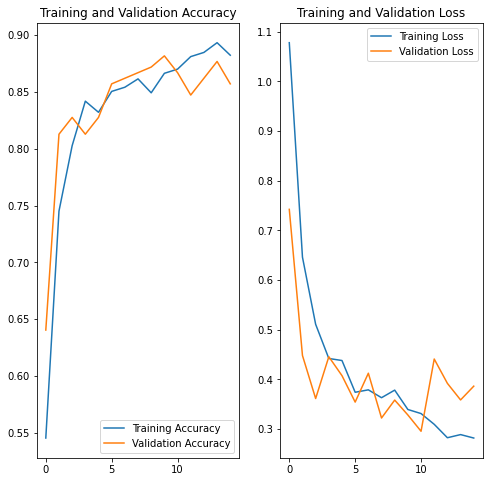

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [116]:
x_train = np.concatenate([x for x, y in tr_ds], axis = 0)
y_train = np.concatenate([y for x, y in tr_ds], axis = 0)
x_test = np.concatenate([x for x, y in te_ds], axis = 0)
y_test = np.concatenate([y for x, y in te_ds], axis = 0)

## Evaluate the model using the test data using `evaluate`

In [117]:

print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 1s 170ms/step - loss: 0.2914 - accuracy: 0.8833
test loss, test acc: [0.29136383533477783, 0.8833333253860474]


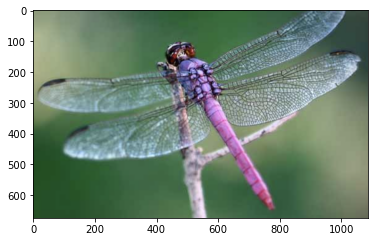

This image most likely belongs to dragonflies with a 97.52 percent confidence.


In [120]:
#predict
p_path = 'purple_drangonfly.jpg'

img_p = PIL.Image.open(p_path)
plt.imshow(img_p)
plt.show()

img = tf.keras.utils.load_img(
    p_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

## Use **shapley additive explanations** to explain the output of model

In [28]:
explainer = shap.GradientExplainer(model, x_train)

In [29]:
sv = explainer.shap_values(x_test[:10])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


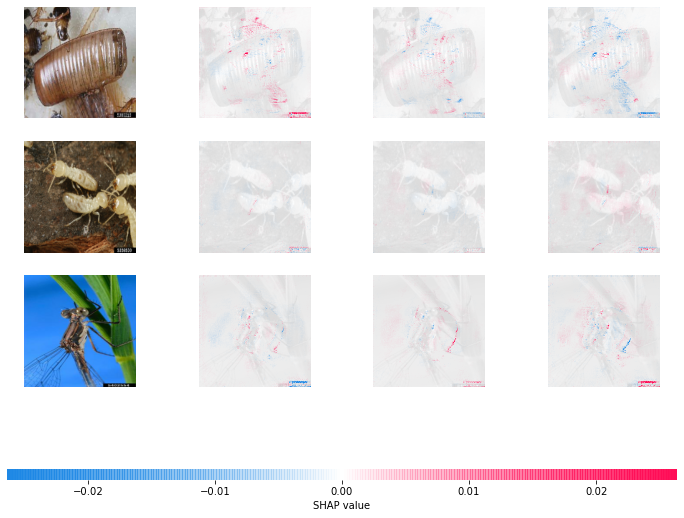

In [88]:
shap.image_plot([sv[i] for i in range(3)], x_test[85:88]) 